In [1]:
import csv
import os
from imageio import imread
import numpy as np

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd 

df = pd.DataFrame(columns=['image', 'measure'])
df.head()

data_path = '../drivingData'
csv_fname = 'driving_log.csv'
data_files = [] 

for file in os.listdir(data_path):
    if file.endswith(".csv"):
        data_files.append(file)
print(f'There are files {data_files} in data_path')

There are files ['snack2.csv', 'driving_log.csv', 'center_driving_log.csv', 'driving_log_t2.csv', 'snake.csv', 'big2track.csv'] in data_path


In [3]:
# all cameras      
for file in data_files:
    with open(os.path.join(data_path, file)) as csvf:
        next(csvf)
        reader = csv.reader(csvf)
        for line in reader:
            for i in range(3):
                source_path = line[i]
#                     source_path = line[0]
                file_path = source_path.split('/')[-1]
        #         print(file_path)

        #         print(measurement)
        #         measurements.append(measurement)
                if i == 0:
                    measurement = float(line[3])
                elif i == 1:
                    measurement = float(line[3]) + 0.1
                elif i == 2:
                    measurement = float(line[3]) - 0.1
                nano_df = pd.DataFrame([[file_path, measurement]], columns=['image', 'measure'])
                df = df.append(nano_df, ignore_index=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62994 entries, 0 to 62993
Data columns (total 2 columns):
image      62994 non-null object
measure    62994 non-null float64
dtypes: float64(1), object(1)
memory usage: 984.4+ KB


In [28]:
df.head()

,image,measure
0,center_2016_12_01_13_30_48_287.jpg,0.0
1,left_2016_12_01_13_30_48_287.jpg,0.1
2,right_2016_12_01_13_30_48_287.jpg,-0.1
3,center_2016_12_01_13_30_48_404.jpg,0.0
4,left_2016_12_01_13_30_48_404.jpg,0.1


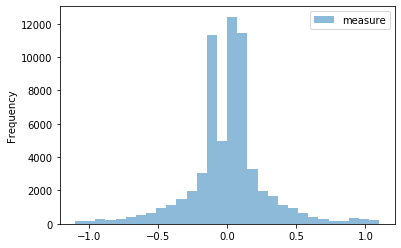

In [5]:
ax = df.plot.hist(bins=30, alpha=0.5)

In [3]:
# only front camera
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd 

for file in data_files:
    with open(os.path.join(data_path, file)) as csvf:
        reader = csv.reader(csvf)
        for line in reader:
                source_path = line[0]
#                     source_path = line[0]
                file_path = source_path.split('/')[-1]
        #         print(file_path)
                measurement = float(line[3])
                nano_df = pd.DataFrame([[file_path, measurement]], columns=['image', 'measure'])
                df = df.append(nano_df, ignore_index=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21004 entries, 0 to 21003
Data columns (total 2 columns):
image      21004 non-null object
measure    21004 non-null float64
dtypes: float64(1), object(1)
memory usage: 328.3+ KB


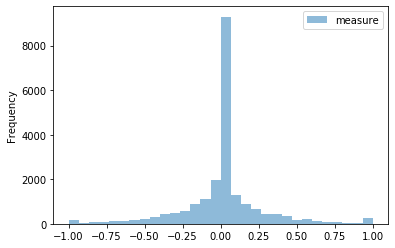

In [5]:
ax = df.plot.hist(bins=30, alpha=0.5)

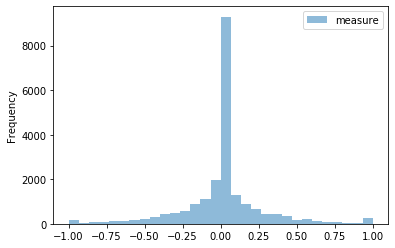

In [5]:
ax = df.plot.hist(bins=30, alpha=0.5)

In [4]:
norm_df= []
norm_df = df.drop(df[(df['measure'] < 0.02) & (df['measure'] > -0.02)].index)
ax1 = norm_df.plot.hist(bins=30, alpha=0.5)

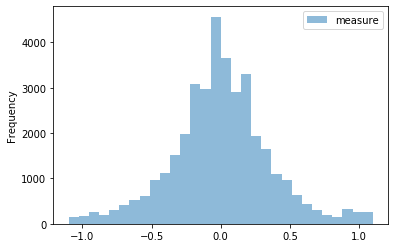

In [8]:
norm_df= []
norm_df = df.drop(df[(df['measure'] < 0.02) & (df['measure'] > -0.01)].index)
norm_df = norm_df.drop(norm_df[(norm_df['measure'] < -0.099) & (norm_df['measure'] > -0.12)].index)
norm_df = norm_df.drop(norm_df[(norm_df['measure'] < 0.12) & (norm_df['measure'] > 0.095)].index)
ax1 = norm_df.plot.hist(bins=30, alpha=0.5)

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Flatten, Dense, Lambda, Cropping2D

In [22]:
# from tensorflow.keras.backend import resize_images


# Nvidia net
model_name = "nvidia_net" 
model = Sequential()
input_shape = (80, 160, 3)
model.add(Cropping2D(cropping=((25,10), (0,0)), input_shape=input_shape))
# model.add(Lambda(lambda img: resize_images(img, 2, 2, data_format="channels_first")))
# model.add(Lambda(lambda img: resize_images(img, 1/2, 1/2, 
#                                            data_format="channels_last", interpolation='bilinear')))
model.add(Lambda(lambda x: tf.cast(x, tf.float32) / 255.0))
model.add(layers.Conv2D(3, (1, 1), 1,
                        padding="valid"))

# first convolution layer
model.add(layers.Conv2D(24, (5, 5), 1,
                        padding="valid"))  # filter num, kernel size, stride, padding
model.add(layers.BatchNormalization(axis=-1))
model.add(layers.Activation("relu"))
# model.add(layers.MaxPooling2D(pool_size=(2, 2), padding="valid"))
# second convolution layer, kernel_regularizer=regularizers.l2(0.1)
model.add(layers.Conv2D(36, (5, 5), 1,
                        padding="valid"))
model.add(layers.BatchNormalization(axis=-1))
model.add(layers.Activation("relu"))
# third conv layer
model.add(layers.Conv2D(48, (3, 3), 1,
                        padding="valid"))
model.add(layers.BatchNormalization(axis=-1))
model.add(layers.Activation("relu"))
# forth conv layer
model.add(layers.Conv2D(64, (3, 3), 1,
                        padding="valid"))
model.add(layers.BatchNormalization(axis=-1))
model.add(layers.Activation("relu"))
model.add(layers.MaxPooling2D(pool_size=(2, 2), padding="valid"))
model.add(layers.Flatten())
# first fully connected layer
model.add(layers.Dense(120))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Dropout(0.5))
# second fully connected layer
model.add(layers.Dense(84))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Dropout(0.5))
# third fully connected layer
model.add(layers.Dense(10))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
# output layer
model.add(layers.Dense(1))
# model.add(layers.Activation("softmax"))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d (Cropping2D)      (None, 45, 160, 3)        0         
_________________________________________________________________
lambda (Lambda)              (None, 45, 160, 3)        0         
_________________________________________________________________
conv2d (Conv2D)              (None, 45, 160, 3)        12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 41, 156, 24)       1824      
_________________________________________________________________
batch_normalization (BatchNo (None, 41, 156, 24)       96        
_________________________________________________________________
activation (Activation)      (None, 41, 156, 24)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 152, 36)       2

In [10]:

# Nvidia net without batch normalization
model_name = "nvidia_one" 
model = Sequential()
input_shape = (80, 160, 3)
model.add(Cropping2D(cropping=((25,10), (0,0)), input_shape=input_shape))
# model.add(Lambda(lambda img: resize_images(img, 2, 2, data_format="channels_first")))
# model.add(Lambda(lambda img: resize_images(img, 1/2, 1/2, 
#                                            data_format="channels_last", interpolation='bilinear')))
model.add(Lambda(lambda x: tf.cast(x, tf.float32) / 255.0 - 0.5))
# model.add(layers.Conv2D(3, (1, 1), 1,
#                         padding="valid"))

# first convolution layer
model.add(layers.Conv2D(24, (5, 5), 1,
                        padding="valid"))  # filter num, kernel size, stride, padding
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
# model.add(layers.MaxPooling2D(pool_size=(2, 2), padding="valid"))
# second convolution layer, kernel_regularizer=regularizers.l2(0.1)
model.add(layers.Conv2D(36, (5, 5), 2,
                        padding="valid"))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
# third conv layer
model.add(layers.Conv2D(48, (3, 3), 2,
                        padding="valid"))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
# forth conv layer
model.add(layers.Conv2D(64, (3, 3), 1,
                        padding="valid"))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
# model.add(layers.MaxPooling2D(pool_size=(2, 2), padding="valid"))
model.add(layers.Flatten())
# first fully connected layer
model.add(layers.Dense(120))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Dropout(0.5))
# second fully connected layer
model.add(layers.Dense(84))
model.add(layers.BatchNormalization())
model.add(layers.Activation("relu"))
model.add(layers.Dropout(0.5))
# third fully connected layer
model.add(layers.Dense(10))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
# output layer
model.add(layers.Dense(1))
# model.add(layers.Activation("softmax"))

In [5]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cropping2d_1 (Cropping2D)    (None, 45, 160, 3)        0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 45, 160, 3)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 41, 156, 24)       1824      
_________________________________________________________________
batch_normalization_7 (Batch (None, 41, 156, 24)       96        
_________________________________________________________________
activation_6 (Activation)    (None, 41, 156, 24)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 19, 76, 36)        21636     
_________________________________________________________________
batch_normalization_8 (Batch (None, 19, 76, 36)       

In [ ]:
BS = 100
target_size = (80, 160)
# directory = os.path.join(data_path,"IMG")
directory = data_path
dataframe = norm_df
datagen=ImageDataGenerator(validation_split=0.2)
train_generator=datagen.flow_from_dataframe(dataframe=dataframe,
                                            directory=directory,
                                            x_col="image",
                                            y_col="measure",
                                            subset="training",
                                            batch_size=BS,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="raw",
                                            target_size=target_size)

valid_generator=datagen.flow_from_dataframe(dataframe=dataframe,
                                            directory=directory,
                                            x_col="image",
                                            y_col="measure",
                                            subset="validation",
                                            batch_size=BS,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="raw",
                                            target_size=target_size)

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

NUM_EPOCHS = 20
INIT_LR = 2*1e-3
        
opt = Adam(lr=INIT_LR, decay=INIT_LR / (NUM_EPOCHS * 0.5))
model.compile(loss="mse", optimizer=opt, metrics=["mse"])

checkpointer = ModelCheckpoint(filepath=f"{model_name}_bw.h5", 
                               monitor = 'val_mse',
                               verbose=1, 
                               save_best_only=True)

# H = model.fit_generator(aug.flow(X_train, y_train, batch_size=BS),
#                         validation_data=(X_valid, y_valid),
#                         steps_per_epoch=X_train.shape[0] // BS,
#                         epochs=NUM_EPOCHS,
#                         callbacks=[checkpointer],
#                         class_weight=classWeight,
#                         verbose=1)
# H = model.fit(X_train, y_train, validation_split=0.2,
#           shuffle=True, epochs=NUM_EPOCHS, batch_size=BS,
#           callbacks=[checkpointer], verbose=1)

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

H = model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=NUM_EPOCHS,
                    callbacks=[checkpointer]
)

model.save(f'{model_name}.h5')

Found 29548 validated image filenames.
Found 7387 validated image filenames.
Epoch 1/20
294/295 [============================>.] - ETA: 0s - loss: 0.7854 - mse: 0.7861
Epoch 00001: val_mse improved from inf to 0.03063, saving model to nvidia_one_bw.h5
295/295 [==============================] - 104s 354ms/step - loss: 0.7837 - mse: 0.7844 - val_loss: 0.0306 - val_mse: 0.0306
Epoch 2/20
294/295 [============================>.] - ETA: 0s - loss: 0.1587 - mse: 0.1587
Epoch 00002: val_mse improved from 0.03063 to 0.02618, saving model to nvidia_one_bw.h5
295/295 [==============================] - 99s 335ms/step - loss: 0.1586 - mse: 0.1586 - val_loss: 0.0262 - val_mse: 0.0262
Epoch 3/20
294/295 [============================>.] - ETA: 0s - loss: 0.0933 - mse: 0.0933
Epoch 00003: val_mse improved from 0.02618 to 0.02383, saving model to nvidia_one_bw.h5
295/295 [==============================] - 96s 325ms/step - loss: 0.0931 - mse: 0.0932 - val_loss: 0.0238 - val_mse: 0.0238
Epoch 4/20
294/29

In [16]:
def get_model_memory_usage(batch_size, model):
    import numpy as np
    from tensorflow.keras import backend as K

    shapes_mem_count = 0
    internal_model_mem_count = 0
    for l in model.layers:
        layer_type = l.__class__.__name__
        if layer_type == 'Model':
            internal_model_mem_count += get_model_memory_usage(batch_size, l)
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in set(model.trainable_weights)])
    non_trainable_count = np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])

    number_size = 4.0
    if K.floatx() == 'float16':
         number_size = 2.0
    if K.floatx() == 'float64':
         number_size = 8.0

    total_memory = number_size*(batch_size*shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3) + internal_model_mem_count
    return gbytes

get_model_memory_usage(BS, model)

TypeError: Variable is unhashable if Tensor equality is enabled. Instead, use tensor.experimental_ref() as the key.

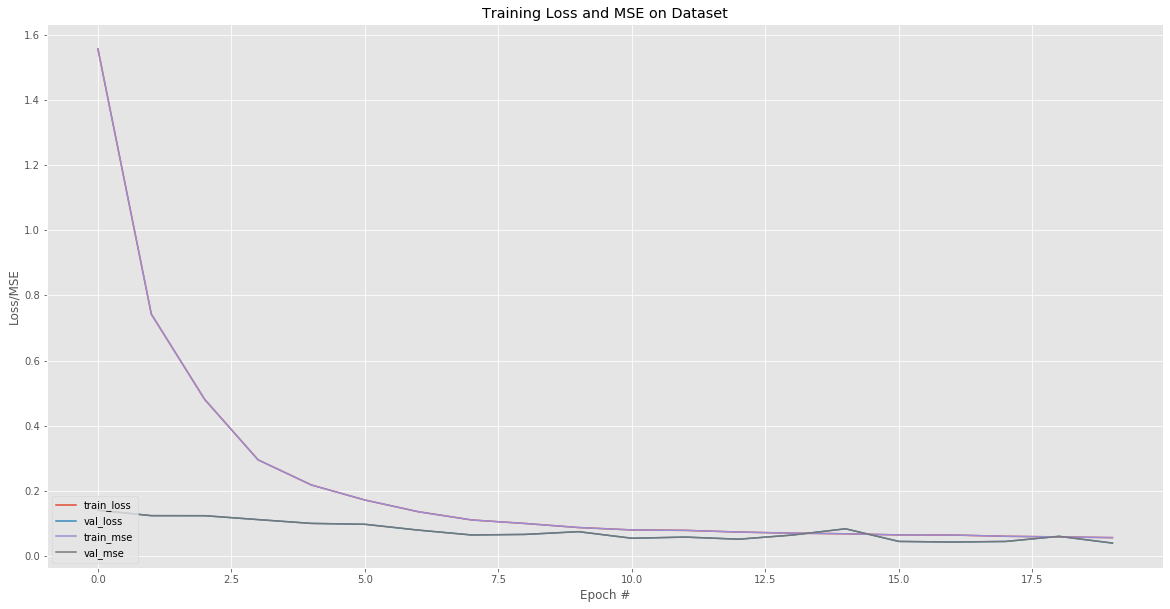

In [25]:
# plot the training loss and accuracy
import matplotlib.pyplot as plt
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize=(20,10))
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["mse"], label="train_mse")
plt.plot(N, H.history["val_mse"], label="val_mse")
plt.title("Training Loss and MSE on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/MSE")
plt.legend(loc="lower left")
plt.savefig(f"{model_name}.png")

In [5]:
# dinamicatly allocate GPU memory if needed
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.2
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)